2D visualization with data cleaning and PCA

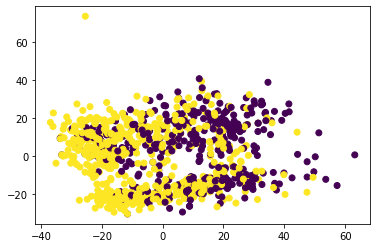

In [15]:
import os
import numpy as np 
import pandas as pd
import time
import matplotlib.pyplot as plt

nba_data = pd.read_csv("NBA5Sene.csv")  #we opened our data with pandas
nba_data.head()

nba_data.iloc[:,-1] = nba_data.iloc[:,-1].map(dict(EVET=1, HAYIR=0))  #We updated the y column to 0 -1
nba_data_trim = nba_data.iloc[:,1:] #we didn't get the player names
data = nba_data_trim.to_numpy()  #we converted our data to numpy
x_data = data[:,:-1]

#We assign values to the nan ones and edit x_data
x_data = np.nan_to_num(x_data, copy=True)  
y_data = data[:,-1]

#data to train
train_shape=(x_data.shape[0]*70)//100 #the first 70 data will be trained
x_train, y_train = x_data[:train_shape], y_data[:train_shape]

#data to test
x_test, y_test = x_data[train_shape:], y_data[train_shape:]

from sklearn.decomposition import PCA   #data visualization (PCA)

pca = PCA(n_components=2)
pca.fit(x_train)
X_pca = pca.transform(x_train)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train)


Logistic Regression

In [16]:
class LogRes:

    def __init__(self, feature_count=19):
        np.random.seed(int(time.time()))
        self.W = np.zeros(shape=feature_count)

        self.b = 0

    def prepare_data(self, x_train, y_train):

        x_train = np.array(x_train, 'float64')
        y_train = np.array(y_train, 'float64')
        return x_train, y_train


    def train(self, x_train, y_train, n_epochs=100, lr=0.05):
        
        n_samples = x_train.shape[0]

        for i in range(n_epochs):
            scores = x_train.dot(self.W) + self.b
            sig_scores = 1/(1 + np.exp(-scores))

            dw = (1 / n_samples) * np.dot(x_train.T, (sig_scores - y_train))
            db = (1 / n_samples) * np.sum(sig_scores - y_train)

            self.W -= dw * lr
            self.b -= db * lr

    def test(self, x_train):
        #e produce our estimated scores
        scores = x_train.dot(self.W) + self.b

        #We use the sigmoid function to fit the scores to values between 1 and 0, to convert them into probabilities.
      
        sig_scores = 1/(1 + np.exp(-scores))

        #To make our predictions ready, we arrange the scores less than 0.5 as 0 and the remaining scores as 1.
        predictions = np.zeros(shape=sig_scores.shape)
        predictions[sig_scores>=0.5] = 1
        predictions[sig_scores<0.5] = 0

        return predictions

    def test_detailed(self, x_train):
        # we produce our estimated scores
        scores = x_train.dot(self.W) + self.b

  
        sig_scores = 1/(1 + np.exp(-scores))

        predictions = np.zeros(shape=sig_scores.shape)
        predictions[sig_scores>=0.5] = 1
        predictions[sig_scores<0.5] = 0

        return predictions, sig_scores,scores

In [17]:
#nba data lojistic regresyon
classifier = LogRes(x_train.shape[1])

x_train, y_train = classifier.prepare_data(x_train,y_train)
x_test, y_test = classifier.prepare_data(x_test,y_test)

start = time.time()
classifier.train(x_train, y_train, n_epochs=10000)
predictions_test = classifier.test(x_test)
print(time.time()-start ," sec")  #training time

acc_score=(predictions_test == y_test).sum() / len(predictions_test)
print("Lojistic score-->",acc_score)

#nba veri PCA lojistic regresyon
classifierPCA = LogRes(X_pca.shape[1])

start = time.time()
classifierPCA.train(X_pca, y_train, n_epochs=10000)
X_pca_test = pca.transform(x_test)
predictions_test = classifierPCA.test(X_pca_test)
print(time.time()-start , " sec") #training time

acc_score=(predictions_test == y_test).sum() / len(predictions_test)
print("Lojistic PCA score -->",acc_score)

#predictions_test, probs, scores = classifierPCA.test_detailed(X_pca_test)  #test,sigmoid score ,function 
#[(pred, prob, score) for pred, prob, score in zip(predictions_test, probs, scores)]
#print(classifier.W*x_test+classifier.b) #function

#sklearn logistic
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
clf = LogisticRegression(C=0.001,max_iter=10000)
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print("Sklearn lojistic score-->",accuracy_score(y_test,y_pred))

#sklearn PCA logistic
clf = LogisticRegression(C=0.00001,max_iter=1000)
clf.fit(X_pca, y_train)
y_pred=clf.predict(X_pca_test)
print("PCA sklearn lojistic score-->",accuracy_score(y_test,y_pred))





0.8055830001831055  sec
Lojistic score--> 0.6865671641791045
0.5039913654327393  sec
Lojistic PCA score --> 0.5621890547263682
Sklearn lojistic score--> 0.7064676616915423
PCA sklearn lojistic score--> 0.7064676616915423


SVM(Support Vector Machines)

In [18]:
from sklearn.svm import SVC
import time

start = time.time()
svclassifier = SVC(kernel='poly',C=37,degree=4)
svclassifier.fit(x_train, y_train)
y_pred = svclassifier.predict(x_test)
print(time.time()-start," sec")     #training time

from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
acc=accuracy_score(y_pred,y_test)
#print("W(weight)-->",svclassifier.coef_)
print("SVM score-->{:.2f}".format(acc))
print("confusion matrix-->",confusion_matrix(y_test, y_pred))
#print("report-->",classification_report(y_test, y_pred))



0.09853339195251465  sec
SVM score-->0.72
confusion matrix--> [[ 96  44]
 [ 70 192]]


Determine the C parameter for the best prediction score

In [19]:
scores = []
for i in range(1,50):
  start = time.time()
  svclassifier = SVC(kernel='poly',C=i,degree=4)
  svclassifier.fit(x_train, y_train)
  y_pred = svclassifier.predict(x_test)

  acc = accuracy_score(y_test,y_pred)
  elapsed_time = time.time()-start
  scores.append(acc)

  print("time {0:.2f} s, acc {1:.2f}, i {2}".format(elapsed_time, acc, i))

time 0.05 s, acc 0.68, i 1
time 0.04 s, acc 0.69, i 2
time 0.04 s, acc 0.69, i 3
time 0.04 s, acc 0.69, i 4
time 0.04 s, acc 0.70, i 5
time 0.05 s, acc 0.69, i 6
time 0.04 s, acc 0.70, i 7
time 0.04 s, acc 0.70, i 8
time 0.05 s, acc 0.70, i 9
time 0.05 s, acc 0.70, i 10
time 0.06 s, acc 0.70, i 11
time 0.05 s, acc 0.70, i 12
time 0.05 s, acc 0.70, i 13
time 0.05 s, acc 0.71, i 14
time 0.06 s, acc 0.71, i 15
time 0.06 s, acc 0.71, i 16
time 0.06 s, acc 0.71, i 17
time 0.06 s, acc 0.71, i 18
time 0.06 s, acc 0.71, i 19
time 0.06 s, acc 0.71, i 20
time 0.06 s, acc 0.71, i 21
time 0.07 s, acc 0.71, i 22
time 0.08 s, acc 0.70, i 23
time 0.07 s, acc 0.70, i 24
time 0.08 s, acc 0.70, i 25
time 0.07 s, acc 0.71, i 26
time 0.07 s, acc 0.71, i 27
time 0.07 s, acc 0.71, i 28
time 0.08 s, acc 0.71, i 29
time 0.07 s, acc 0.71, i 30
time 0.08 s, acc 0.71, i 31
time 0.09 s, acc 0.71, i 32
time 0.07 s, acc 0.71, i 33
time 0.09 s, acc 0.71, i 34
time 0.09 s, acc 0.71, i 35
time 0.09 s, acc 0.71, i 36
t

Artificial Neural Networks

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

start = time.time()
clf=MLPClassifier(activation='relu',alpha=0.1, hidden_layer_sizes=(15,), random_state=1,
              solver='lbfgs',max_iter=10000)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(time.time()-start," sec")     #training time

#print("MLP Coefs-->",clf.coefs_)
print("MLP score-->",accuracy_score(y_test,y_pred))
print("MLP matrix-->",confusion_matrix(y_test, y_pred))


1.5638675689697266  sec
MLP score--> 0.6940298507462687
MLP matrix--> [[ 82  58]
 [ 65 197]]


Coefficients analysis

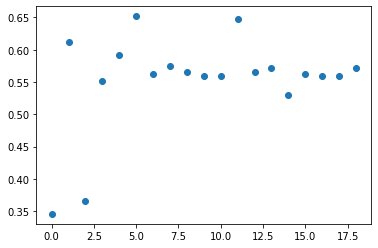

In [21]:
from copy import deepcopy

accuracies = np.zeros(classifier.W.shape)     #By giving 0 to each coefficient, we looked at the prediction scores and visualized it so that we can see which features are important.
for i, w in enumerate(classifier.W):
  classifierTemp = deepcopy(classifier)
  classifierTemp.W[i] = 0

  predictions_temp = classifierTemp.test(x_train)
  
  acc = sum(1 for a, b in zip(predictions_temp, y_test) if a == b) / len(predictions_test)
  accuracies[i] = acc

plt.scatter(range(len(accuracies)), accuracies)
plt.show()

K-Means

0.23939776420593262  sec


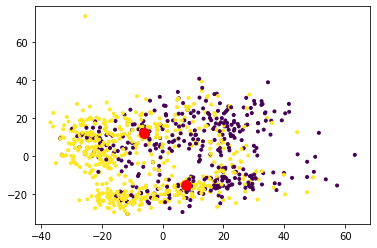

In [22]:
import numpy as np
from math import sqrt
import random
import matplotlib.pyplot as plt

class Kmeans:
    def __init__(self, n_clusters=4):
        self.K = n_clusters
        
    def train(self, x_train):
        self.centroids = x_train[np.random.choice(len(x_train), self.K, replace=False)] #cluster center points
        self.intial_centroids = self.centroids #baseline set center points
        self.prev_label, self.labels = None, np.zeros(len(x_train)) #labels
        while not np.all(self.labels == self.prev_label) :
            self.prev_label = self.labels #first tags 
            self.labels = self.test(x_train)
            self.update_centroid(x_train)
        return self
        
    def test(self, x_train):
        return np.apply_along_axis(self.compute_label, 1, x_train)

    def compute_label(self, x_train):
        return np.argmin(np.sqrt(np.sum((self.centroids - x_train)**2, axis=1))) #distance calculation

    def update_centroid(self,x_train):
        self.centroids = np.array([np.mean(x_train[self.labels == k], axis=0)  for k in range(self.K)])

#pca k-means
start = time.time()
km=Kmeans(n_clusters=2) 
km.train(X_pca)
km.test(X_pca_test)
print(time.time()-start , " sec")
km.labels #predictive clustering class

plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', c=y_train)
plt.scatter(km.centroids[:, 0], km.centroids[:,1], c='r',s=100)  #representation of cluster center points






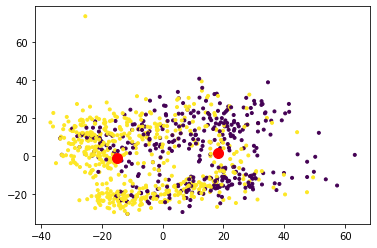

In [23]:
#k-means skelarn 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_pca)
kmeans.predict(X_pca_test)
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', c=y_train)

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='r',s=100) #With sklearn we showed the cluster center points